In [97]:
# libraries
import os
import glob
import numpy as np
import pandas as pd
import warnings

import squarify
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import re
import plotly.graph_objects as go
import plotly.express as px

In [98]:
# read data

## products dataset
path = 'data/learnplatform-covid19-impact-on-digital-learning/'
products_info = pd.read_csv(path + "products_info.csv")
products_info.columns = [x.lower().replace(' ','_') for x in products_df.columns]

In [99]:
products_info.head()

,lp_id,url,product_name,provider/company_name,sector(s),primary_essential_function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


In [100]:
## districts dataset
districts_info = pd.read_csv(path +"districts_info.csv")

In [101]:
districts_info.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
## engagement dataset
path = 'data/learnplatform-covid19-impact-on-digital-learning/engagement_data/' 
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.split("/")[-1].split(".")[0]
    df["district_id"] = district_id
    li.append(df)
engagement = pd.concat(li)
engagement = engagement.reset_index(drop=True)

In [103]:
engagement.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,29322.0,0.04,1.30,3188
1,2020-01-01,57084.0,0.04,0.43,3188
2,2020-01-01,99916.0,0.09,5.20,3188
3,2020-01-01,58235.0,0.00,NaN,3188
4,2020-01-01,11585.0,0.04,1.30,3188


Eliminación de distritos con estados NaN

In [104]:
districts_info = districts_info[districts_info.state.notna()].reset_index(drop=True)

Codificación de los sectores de productos

In [105]:
temp_sectors = products_info['sector(s)'].str.get_dummies(sep="; ")
temp_sectors.columns = [f"sector_{re.sub(' ', '', c)}" for c in temp_sectors.columns]
products_info = products_info.join(temp_sectors)
products_info.drop("sector(s)", axis=1, inplace=True)

del temp_sectors

División de la función esencial principal

In [106]:
products_info['primary_function_main'] = products_info['primary_essential_function'].apply(lambda x: x.split(' - ')[0] if x == x else x)
products_info['primary_function_sub'] = products_info['primary_essential_function'].apply(lambda x: x.split(' - ')[1] if x == x else x)

# Synchronize similar values
products_info['primary_function_sub'] = products_info['primary_function_sub'].replace({'Sites, Resources & References' : 'Sites, Resources & Reference'})
products_info.drop("primary_essential_function", axis=1, inplace=True)

Después del preprocesamiento, nos queda un marco de datos distritos_info reducido con 176 distritos y el aspecto del marco de datos product_info es el siguiente:

In [107]:
products_info.head()

,lp_id,url,product_name,provider/company_name,sector_Corporate,sector_HigherEd,sector_PreK-12,primary_function_main,primary_function_sub
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,0,0,1,LC,Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",0,0,1,LC,Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",0,0,1,LC,"Sites, Resources & Reference"
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,0,1,1,LC,Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,0,0,1,LC,Digital Learning Platforms


Además, concatenaremos los datos de participación de todos los distritos restantes en un marco de datos agregando la columna clave district_id a cada archivo de participación como se muestra a continuación.

In [108]:
engagement.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,29322.0,0.04,1.30,3188
1,2020-01-01,57084.0,0.04,0.43,3188
2,2020-01-01,99916.0,0.09,5.20,3188
3,2020-01-01,58235.0,0.00,NaN,3188
4,2020-01-01,11585.0,0.04,1.30,3188


In [109]:
temp = []

for district in districts_info.district_id.unique():
    df = pd.read_csv(f'{path}/{district}.csv', index_col=None, header=0)
    df["district_id"] = district
    temp.append(df)
    
    
engagement = pd.concat(temp)
engagement = engagement.reset_index(drop=True)

Para la mayoría de los distritos escolares (133) hay 366 días únicos disponibles. Sin embargo, para 43 distritos escolares hay menos de 366 días únicos de datos disponibles. Por ejemplo, para el distrito 3670 solo hay datos disponibles desde 2020-02-15 hasta 2020-03-02 o para el distrito 2872 solo hay datos disponibles para enero de 2020 y luego dos días individuales más en febrero y marzo.

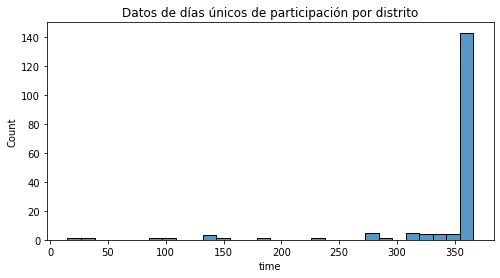

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.histplot(engagement.groupby('district_id').time.nunique(), bins=30)
ax.set_title('Datos de días únicos de participación por distrito')
plt.show()

Para que los datos sean más fáciles de comparar, solo consideraremos los distritos con datos de participación para todos los días en 2020.

In [111]:
# Delete previously created engagement dataframe and create a new one
del engagement

temp = []

for district in districts_info.district_id.unique():
    df = pd.read_csv(f'{path}/{district}.csv', index_col=None, header=0)
    df["district_id"] = district
    if df.time.nunique() == 366:
        temp.append(df)

engagement = pd.concat(temp)
engagement = engagement.reset_index(drop=True)

In [112]:
districts_info = districts_info[districts_info.district_id.isin(engagement.district_id.unique())].reset_index(drop=True)
products_info = products_info[products_info['lp_id'].isin(engagement.lp_id.unique())].reset_index(drop=True)

Además, si miramos algunos distritos de muestra, podemos ver rápidamente que la mayoría de los distritos utilizan más de los 369 productos únicos de products_info. De hecho, los datos de participación concatenados contienen más de 8000 productos únicos. Dado que no tenemos información adicional sobre la mayoría de estos productos, eliminaremos los datos de participación de productos desconocidos. Esto reduce los datos de interacción aproximadamente a la mitad.

In [114]:
for district in districts_info.district_id.unique()[:10]:
    df = pd.read_csv(f'{path}/{district}.csv', index_col=None, header=0)
    print(f'Distrito {district} usa {df.lp_id.nunique()} productos únicos.')
    
print(f'\nLos datos de participación concatenados contienen {engagement.lp_id.nunique()} productos únicos.')

Distrito 3710 usa 985 productos únicos.
Distrito 7177 usa 4913 productos únicos.
Distrito 9812 usa 5056 productos únicos.
Distrito 6584 usa 3508 productos únicos.
Distrito 1044 usa 5593 productos únicos.
Distrito 7457 usa 4013 productos únicos.
Distrito 1904 usa 2200 productos únicos.
Distrito 5527 usa 4055 productos únicos.
Distrito 7614 usa 4468 productos únicos.
Distrito 2779 usa 3644 productos únicos.

Los datos de participación concatenados contienen 8417 productos únicos.


In [115]:
print(len(engagement))
engagement = engagement[engagement.lp_id.isin(products_info['lp_id'].unique())]
print(len(engagement))

14913939
7784803


Tenga en cuenta que en esta etapa, hemos eliminado bastantes datos. Obviamente, esto puede provocar la pérdida de información. Sin embargo, por otro lado, esto hace que los datos sean más fáciles de comparar y, por lo tanto, puede ayudarnos a encontrar información más rápidamente. Para resumir, hemos eliminado distritos sin ninguna información sobre la ubicación y hemos eliminado distritos con datos incompletos en 2020.

Finally, we will convert the time column to the type datetime64[ns] for easier handling.

In [116]:
engagement.time = engagement.time.astype('datetime64[ns]')

### Análisis inicial de datos exploratorios (EDA)

Comencemos con una EDA simple. En primer lugar, me interesa la diversidad de distritos escolares disponibles. Como puede ver en el gráfico a continuación, los datos disponibles no cubren todos los estados de los EE. UU. (19/50). Los estados con más distritos escolares disponibles son CT (29) y UT (24), mientras que también hay estados con un solo distrito escolar (FL, TN, NY, AZ).

In [118]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

districts_info['state_abbrev'] = districts_info['state'].replace(us_state_abbrev)
districts_info_by_state = districts_info['state_abbrev'].value_counts().to_frame().reset_index(drop=False)
districts_info_by_state.columns = ['state_abbrev', 'num_districts']
fig = go.Figure()
layout = dict(
    title_text = "Number of Available School Districts per State",
    geo_scope='usa',
)

fig.add_trace(
    go.Choropleth(
        locations=districts_info_by_state.state_abbrev,
        zmax=1,
        z = districts_info_by_state.num_districts,
        locationmode = 'USA-states', # set of locations match entries in `locations`
        marker_line_color='white',
        geo='geo',
        colorscale=px.colors.sequential.Teal, 
    )
)
            
fig.update_layout(layout)   
fig.show()

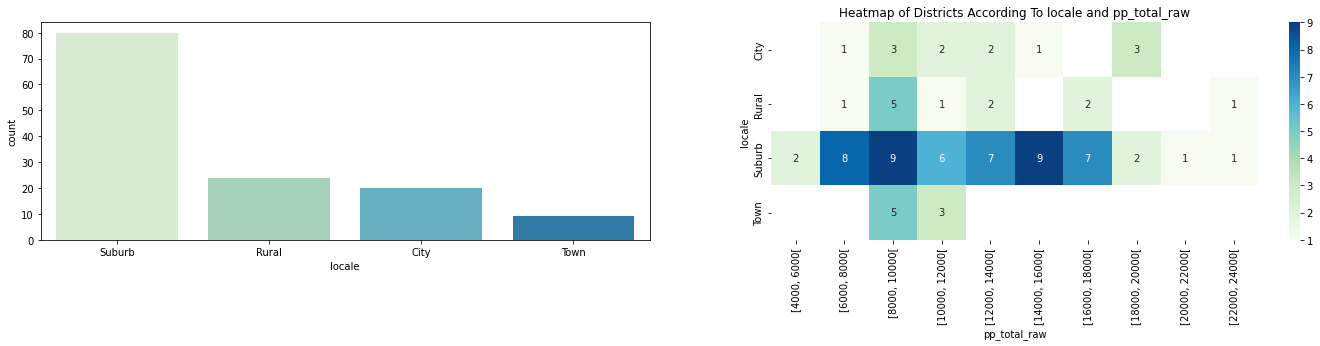

In [119]:
districts_info.pp_total_raw.unique()
temp = districts_info.groupby('locale').pp_total_raw.value_counts().to_frame()
temp.columns = ['amount']

temp = temp.reset_index(drop=False)

temp = temp.pivot(index='locale', columns='pp_total_raw')['amount']
temp = temp[['[4000, 6000[', '[6000, 8000[', '[8000, 10000[', '[10000, 12000[',
       '[12000, 14000[', '[14000, 16000[', '[16000, 18000[', 
       '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', ]]


fig, ax = plt.subplots(1, 2, figsize=(24,4))

sns.countplot(data=districts_info, x='locale', ax=ax[0], palette='GnBu')

sns.heatmap(temp, annot=True,  cmap='GnBu', ax=ax[1])
ax[1].set_title('Heatmap of Districts According To locale and pp_total_raw')
plt.show()

Si miramos las distribuciones de las columnas restantes en distritos_info, puede ver rápidamente que county_connections_ratio solo tiene un valor único que es [0.18, 1 [. Para ser justos, antes de eliminar todas las filas sin información de estado, esta columna tenía otro valor de [1, 2 [pero solo para un punto de datos. Entonces, esta columna realmente no contiene ninguna información valiosa. Quizás podamos obtener este tipo de información de un conjunto de datos externo.

In [121]:
def replace_ranges_pct(range_str):
    if range_str == '[0, 0.2[':
        return 0.1
    elif range_str == '[0.2, 0.4[':
        return 0.3
    elif range_str == '[0.4, 0.6[':
        return 0.5
    elif range_str == '[0.6, 0.8[':
        return 0.7
    elif range_str == '[0.8, 1[':
        return 0.9
    else:
        return np.nan
    
def replace_ranges_raw(range_str):
    if range_str == '[4000, 6000[':
        return 5000
    elif range_str == '[6000, 8000[':
        return 7000
    elif range_str == '[8000, 10000[':
        return 9000
    elif range_str == '[10000, 12000[':
        return 11000
    elif range_str ==  '[12000, 14000[':
        return 13000
    elif range_str ==  '[14000, 16000[':
        return 15000
    elif range_str == '[16000, 18000[':
        return 17000
    elif range_str ==  '[18000, 20000[':
        return 19000
    elif range_str ==  '[20000, 22000[':
        return 21000
    elif range_str ==  '[22000, 24000[':
        return 21000
    else: 
        return np.nan
    
districts_info['pct_black_hispanic_num'] = districts_info['pct_black/hispanic'].apply(lambda x: replace_ranges_pct(x))
districts_info['pct_free_reduced_num'] = districts_info['pct_free/reduced'].apply(lambda x: replace_ranges_pct(x))
districts_info['pp_total_raw_num'] = districts_info['pp_total_raw'].apply(lambda x: replace_ranges_raw(x))

def plot_state_mean_for_var(col):
    temp = districts_info.groupby('state_abbrev')[col].mean().to_frame().reset_index(drop=False)

    fig = go.Figure()
    layout = dict(
        title_text = f"Media {col} por Estado",
        geo_scope='usa',
    )

    fig.add_trace(
        go.Choropleth(
            locations=temp.state_abbrev,
            zmax=1,
            z = temp[col],
            locationmode = 'USA-states', # set of locations match entries in `locations`
            marker_line_color='white',
            geo='geo',
            colorscale=px.colors.sequential.Teal, 
        )
    )

    fig.update_layout(layout)   
    fig.show()

plot_state_mean_for_var('pct_black_hispanic_num')
plot_state_mean_for_var('pct_free_reduced_num')
plot_state_mean_for_var('pp_total_raw_num')

La categoría más común en la columna Función Esencial Primaria es Aprendizaje y Currículo (LC) como se muestra en la figura de abajo a la izquierda. Para las categorías Gestión del aula (CM) y Operaciones de la escuela y el distrito (SDO), hay muchas menos opciones de herramientas disponibles.

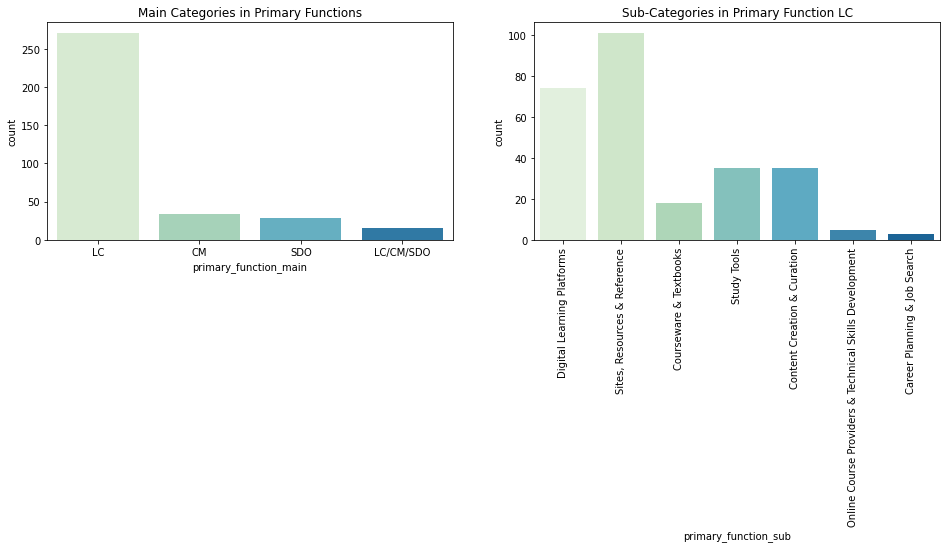

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.countplot(data=products_info, x='primary_function_main', palette ='GnBu', ax=ax[0])
ax[0].set_title('Main Categories in Primary Functions')

sns.countplot(data=products_info[products_info.primary_function_main == 'LC'], x='primary_function_sub', palette ='GnBu', ax=ax[1])
ax[1].set_title('Sub-Categories in Primary Function LC')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

Ahora intentaremos comprender el significado que hay detrás de pct_access y engagement_index
* pct_access:% de estudiantes en el distrito tienen al menos un evento de carga de página de un producto dado y en un día determinado
* engagement_index: eventos de carga de página total por cada 1000 estudiantes de un producto determinado y en un día determinado
En la primera figura a continuación, puede ver el pct_access medio general de todos los productos de la categoría 'Aula virtual'. Para una mejor comprensión, los fines de semana se eliminan de esta visualización, ya que los estudiantes no asistirán a clases los fines de semana y esto agregaría un efecto visual perturbador y dificultaría la comprensión de la trama. Resumamos lo que vemos:
* la fase de educación en el hogar comienza a principios de marzo
* hay una forma de campana entre marzo y julio
* durante julio y agosto hay vacaciones de verano y, por tanto, no hay clases a las que asistir
* después de las vacaciones de verano el pct_access aumenta a un nivel más alto que el observado al comienzo de la pandemia y se mantiene algo constante
* hay algunas gotas en pct_access visibles durante todo el año; pueden ser feriados nacionales u otros feriados
* Zoom y Meet parecen ser los dos productos más populares para las aulas virtuales.


Durante el último trimestre de 2020, podemos ver un pct_access de aproximadamente 15. ¿Qué significa esto? El 15% de los estudiantes del distrito tienen al menos un evento de carga de página de Zoom o Meet. Para ser honesto, eso parece un poco bajo desde el punto de vista de la educación en el hogar, dado que todos los estudiantes deben asistir a clases en un día escolar. Sin embargo, esto parece indicar el hecho de que no todos los estudiantes tuvieron que asistir a clases de manera virtual, pero pudieron ir físicamente a la escuela. A juzgar por este mapa estado por estado de dónde se abren o cierran los edificios escolares, parece que muchas escuelas ofrecieron educación en persona en 2020. Eso significa que, al analizar el aprendizaje digital, probablemente deberíamos centrar nuestro análisis en los distritos donde En realidad, el aprendizaje digital se aplicó para obtener información clave.
Si bien para pct_access Zoom y Meet parecen tener valores aproximadamente similares, podemos ver en el gráfico inferior que Meet tiene más de 4 veces el valor de Zoom para engagement_index en el último trimestre de 2020. ¿Qué significa esto? Si tenemos 1000 eventos de carga de página por cada 1000 estudiantes para Zoom en un día determinado, eso significa que un estudiante usa Zoom una vez al día. Por el contrario, Meet se usa 4 o 5 veces al día en promedio por alumno.
Para aclarar un poco las cosas: si cada estudiante tiene dos aplicaciones en su teléfono, el pct_access indica cuántos de los estudiantes acceden a esta aplicación a diario, pero el engagement_index le dice cuánto se involucran los estudiantes con esa aplicación a diario. 

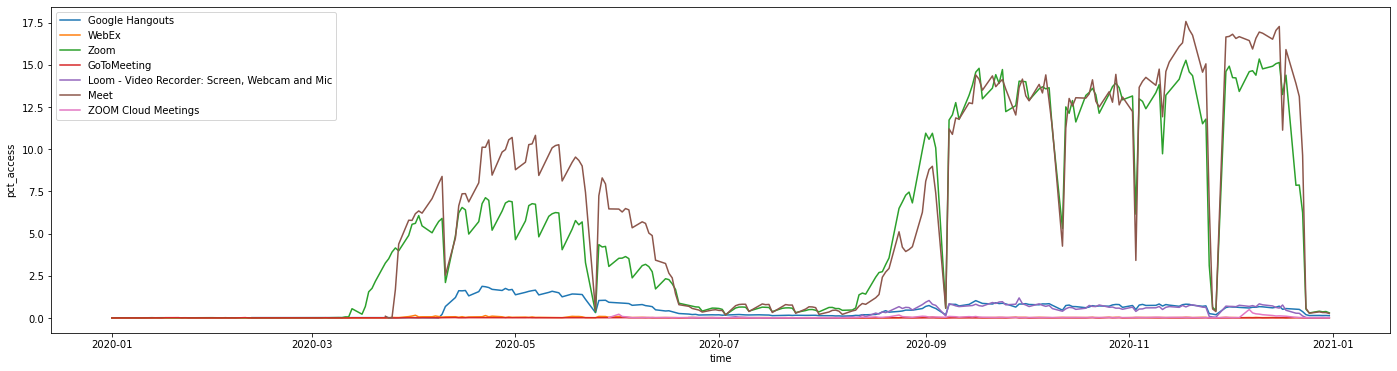

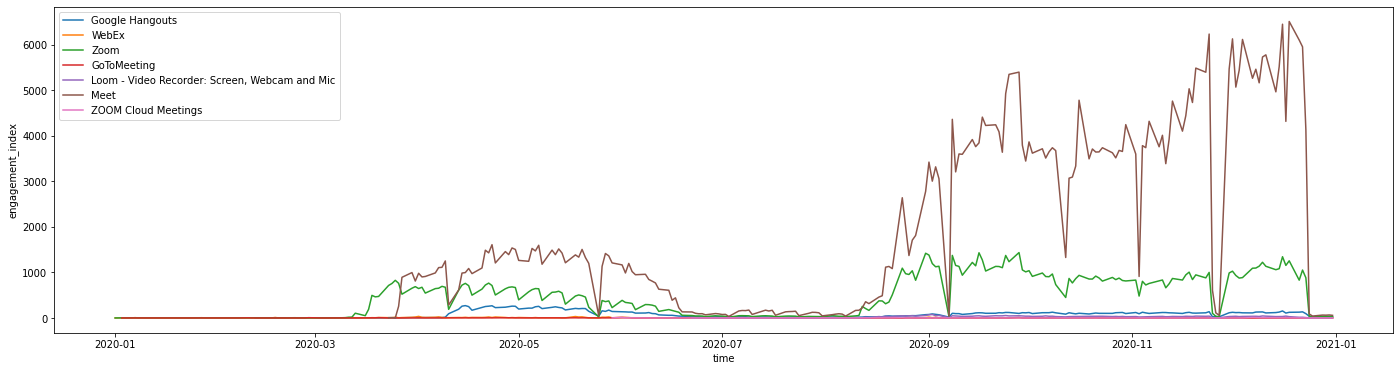

In [126]:
virtual_classroom_lp_id = products_info[products_info.primary_function_sub == 'Virtual Classroom']['lp_id'].unique()

# Remove weekends from the dataframe
engagement['weekday'] = pd.DatetimeIndex(engagement['time']).weekday
engagement_without_weekends = engagement[engagement.weekday < 5]

# Figure 1
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for virtual_classroom_product in virtual_classroom_lp_id:
    temp = engagement_without_weekends[engagement_without_weekends.lp_id == virtual_classroom_product].groupby('time').pct_access.mean().to_frame().reset_index(drop=False)
    sns.lineplot(x=temp.time, y=temp.pct_access, label=products_info[products_info['lp_id'] == virtual_classroom_product]['product_name'].values[0])
plt.legend()
plt.show()

# Figure 2
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for virtual_classroom_product in virtual_classroom_lp_id:
    temp = engagement_without_weekends[engagement_without_weekends.lp_id == virtual_classroom_product].groupby('time').engagement_index.mean().to_frame().reset_index(drop=False)
    sns.lineplot(x=temp.time, y=temp.engagement_index, label=products_info[products_info['lp_id'] == virtual_classroom_product]['product_name'].values[0])
plt.legend()
plt.show()

A continuación, podemos ver los 5 productos más visitados para cada subcategoría de LC ordenados por el pct_access medio para 2020 en todos los distritos. Podemos ver que, en promedio, menos del 5% de los estudiantes acceden a la mayoría de los productos a diario. Las excepciones son YouTube, Google Docs y Canvas. YouTube en este caso es difícil de evaluar, ya que se puede usar para el ocio además de la educación, por lo que debemos tener cuidado aquí. Google Docs parece tener mucho sentido ya que los estudiantes pueden usar Google Docs. Según Canvas es

Canvas es un sistema de gestión de aprendizaje basado en la web, o LMS. Es utilizado por instituciones de aprendizaje, educadores y estudiantes para acceder y administrar materiales de aprendizaje de cursos en línea y comunicarse sobre el desarrollo de habilidades y los logros de aprendizaje.

por lo que también tiene sentido que se acceda a este con bastante frecuencia.

Con respecto a la subcategoría 'Planificación de carrera y búsqueda de empleo', el pct_access promedio es muy bajo. Probablemente esto se deba al hecho de que la planificación de la carrera solo es relevante para los estudiantes mayores. Por lo tanto, probablemente podamos excluir esta subcategoría al inspeccionar el aspecto del aprendizaje digital.

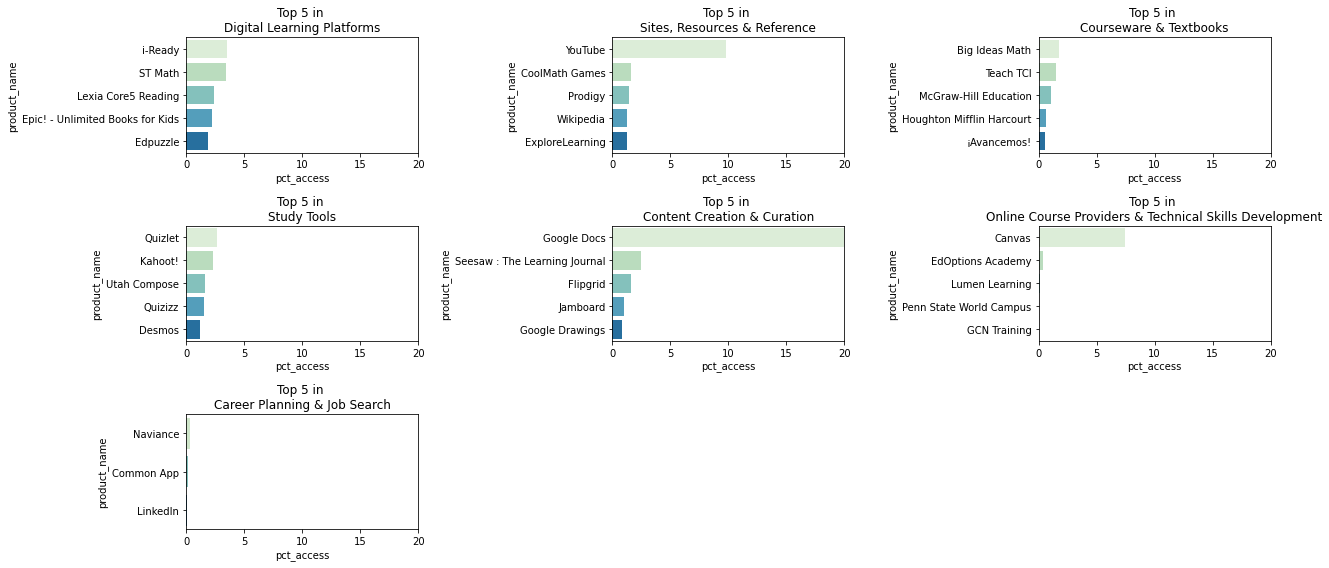

In [128]:
products_info['lp_id'] = products_info['lp_id'].copy()

f, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 8))

i = 0
j = 0
for subfunction in products_info[products_info.primary_function_main == 'LC'].primary_function_sub.unique():
    lp_ids = products_info[products_info.primary_function_sub == subfunction]['lp_id'].unique()

    temp = engagement_without_weekends[engagement_without_weekends.lp_id.isin(lp_ids)]
    temp = temp.groupby('lp_id').pct_access.mean().sort_values(ascending=False).to_frame().reset_index(drop=False)
    temp = temp.merge(products_info[['lp_id', 'product_name']], on='lp_id').head()
    
    sns.barplot(data=temp, x='pct_access', y='product_name', palette='GnBu', ax=ax[i, j])
    
    ax[i, j].set_title(f'Top 5 in \n{subfunction}', fontsize=12)
    ax[i, j].set_xlim([0, 20])
    j = j + 1
    if j == 3:
        i = i + 1
        j = 0
        
f.delaxes(ax[2, 1])
f.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()

Solo en una nota al margen porque vi esto por accidente: 'Among Us', que es un juego multijugador que fue bastante popular durante 2020, también figura como un producto en la categoría principal LC. Por lo tanto, debemos tomar la lista de productos con un grano de sal cuando los evaluamos como 'productos de aprendizaje digital'

In [129]:
products_info[products_info['product_name'] == 'Among Us']

,lp_id,url,product_name,provider/company_name,sector_Corporate,sector_HigherEd,sector_PreK-12,primary_function_main,primary_function_sub
367,32555,http://www.innersloth.com/gameAmongUs.php,Among Us,InnerSloth,0,1,1,LC,"Sites, Resources & Reference"


En el ejemplo anterior, para mostrar la diferencia entre pct_access y engagement_index, elegimos de forma intuitiva productos de la subfunción "Aula virtual" en función de nuestro "conocimiento de dominio" de que la educación presencial no necesita herramientas de videoconferencia, pero durante la pandemia estas herramientas ganaron mucho. de popularidad. Hagamos un análisis rápido y veamos si los datos disponibles reflejan la suposición que habíamos hecho antes.

Para este propósito, promediaremos los datos pct_access y engagement_index durante cada trimestre en 2020 y luego tomaremos la diferencia entre el último trimestre de 2020 y el primer trimestre de 2020. Con base en este enfoque, deberíamos poder ver qué categoría de subfunción obtuvo la mayor participación durante el transcurso de la pandemia en 2020.

Como puede ver en la figura de abajo a la izquierda, los datos reflejan nuestra suposición de que los productos de la subfunción 'Aula virtual' obtuvieron el mayor cambio en pct_access. En segundo lugar, tenemos Learning Management Systems (LMS). Estas dos categorías principales también son las dos categorías principales desde el punto de vista de engagement_index.

/var/folders/fv/cb87vyq954957sywgxh8ngbm0000gn/T/ipykernel_29064/2178814776.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



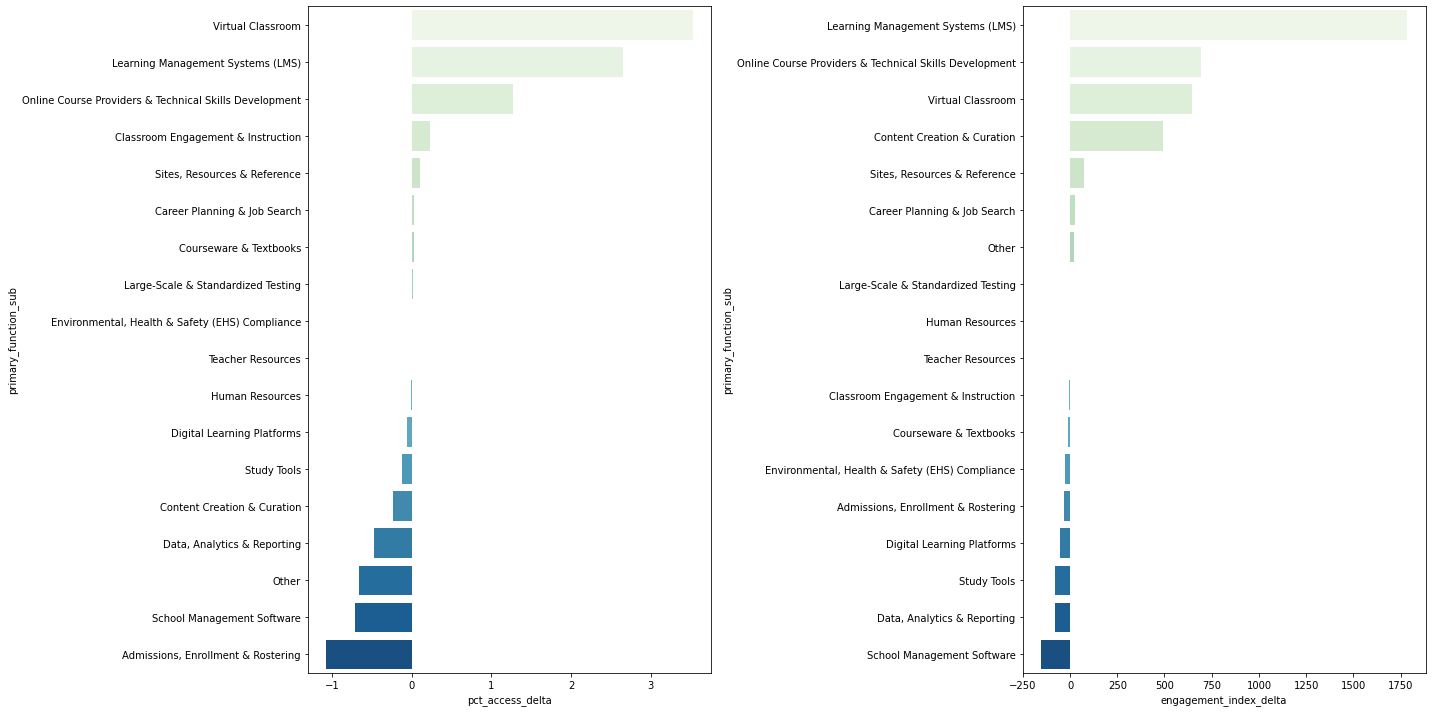

In [131]:
engagement['quarter'] = pd.DatetimeIndex(engagement['time']).quarter.astype(str)

temp = engagement.merge(products_info[['lp_id', 'product_name', 'primary_function_main', 'primary_function_sub']], on='lp_id')
temp = temp[temp.primary_function_sub.notna()]
temp = temp.groupby(['quarter', 'primary_function_sub'])['pct_access', 'engagement_index'].mean().reset_index(drop=False)

temp = temp.pivot(index='primary_function_sub', columns='quarter')[['pct_access', 'engagement_index']].fillna(0)

temp.columns = ["_".join(a) for a in temp.columns.to_flat_index()]

temp['pct_access_delta'] = temp['pct_access_4'] - temp['pct_access_1']
temp['engagement_index_delta'] = temp['engagement_index_4'] - temp['engagement_index_1']
temp=temp.reset_index(drop=False)
#temp = temp.merge(products_info[['lp_id', 'Product Name', 'primary_function_sub']], on='lp_id')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

df = temp.sort_values(by='pct_access_delta', ascending=False)#.head(5)

sns.barplot(data=df, x='pct_access_delta', y='primary_function_sub', palette='GnBu', ax=ax[0])

df = temp.sort_values(by='engagement_index_delta', ascending=False)#.head(5)

sns.barplot(data=df, x='engagement_index_delta', y='primary_function_sub', palette='GnBu', ax=ax[1])
plt.tight_layout()
plt.show()

El mismo enfoque que el anterior se utiliza a continuación para el nivel de producto en lugar del nivel de subfunción.

/var/folders/fv/cb87vyq954957sywgxh8ngbm0000gn/T/ipykernel_29064/964334406.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



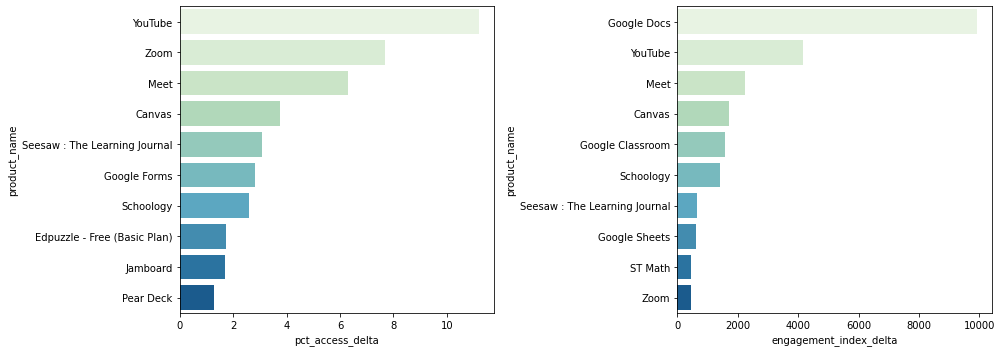

In [135]:
temp = engagement.fillna(0).groupby(['quarter', 'lp_id'])['pct_access', 'engagement_index'].mean().reset_index(drop=False)

temp = temp.pivot(index='lp_id', columns='quarter')[['pct_access', 'engagement_index']].fillna(0)

temp.columns = ["_".join(a) for a in temp.columns.to_flat_index()]

temp['pct_access_delta'] = temp['pct_access_4'] - temp['pct_access_1']
temp['engagement_index_delta'] = temp['engagement_index_4'] - temp['engagement_index_1']
temp = temp.merge(products_info[['lp_id', 'product_name', 'primary_function_sub']], on='lp_id')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

df = temp.sort_values(by='pct_access_delta', ascending=False).head(10)

sns.barplot(data=df, x='pct_access_delta', y='product_name', palette='GnBu', ax=ax[0])

df = temp.sort_values(by='engagement_index_delta', ascending=False).head(10)

sns.barplot(data=df, x='engagement_index_delta', y='product_name', palette='GnBu', ax=ax[1])
plt.tight_layout()
plt.show()

Resumen

* Dependiendo de lo que desee lograr, es posible que desee preseleccionar cuidadosamente los distritos. Tenga en cuenta que el enfoque que abordamos en este cuaderno no necesariamente se adapta a sus propósitos individuales.
* Al analizar el aprendizaje digital, es posible que desee dedicar algún tiempo a averiguar qué distritos realmente aplicaron el aprendizaje digital.